## Sentiment Analysis of Amazon Review Data

In [165]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

#Unterdrückung von Update Hinweisen
import warnings
warnings.filterwarnings('ignore')

In [166]:
with open('config.json') as json_data_file:
    config = json.load(json_data_file)

In [167]:
data = pd.read_csv("./Data_filtered/reviews_Automotive.csv", sep=";")
data.head(5)

,review,rating,product
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00002243X
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00002243X
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00002243X
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00002243X
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00002243X


In [168]:
# 1, 2, 3 = negativ 4, 5 = positiv
data["label"] = pd.cut(data["rating"], bins = config["label_two"]["bins"], labels = config["label_two"]["labels"])
data["label"] = data["label"].astype(str)
data.head(5)

,review,rating,product,label
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00002243X,positiv
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00002243X,positiv
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00002243X,positiv
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00002243X,positiv
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00002243X,positiv


In [169]:
#Build an evenly distribued dataframe
positiv = data[data['label'] =='positiv']
negativ = data[data['label'] =='negativ']

positiv_sample = positiv.sample(n=negativ.label.count(), replace=False, random_state=42)

#Merge postiv und negativ dataframe
balanced_dataset = pd.concat([negativ, positiv_sample])
#data = balanced_dataset

In [170]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

#Vectorizer
vect = CountVectorizer(stop_words="english")
#vect = TfidfVectorizer()

#feature selection
f_select = SelectKBest(f_classif, k=10000)
f_select = SelectPercentile(f_classif, percentile=20)

from sklearn.ensemble import RandomForestClassifier

#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=False)
#clf = LinearSVC(C=1.0, penalty= "l1", max_iter=3000, dual=False)
#clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42)
#clf = LogisticRegression(random_state=42, class_weight=None, max_iter=3000)



#Building the Pipeline
pipeline = Pipeline([('vect', vect),
                     ('f_select', f_select), 
                     ('clf', clf)])

In [171]:
from sklearn import metrics
model = pipeline.fit(X_train, y_train)

#Results step of Pipeline
vectorizer = model.named_steps['vect']
feature_selection = model.named_steps['f_select']
classifier = model.named_steps['clf']


#Accuracy score of Train Data
print("accuracy score: " + str(model.score(X_train, y_train)))

accuracy score: 0.9311881792648675


In [172]:
from sklearn.metrics import accuracy_score
model = pipeline.fit(X_train, y_train)

#Accuracy Score of Model prediction 
print("accuracy score: " + str(model.score(X_test, y_test)))

#Report on prediction of model
predictions = model.predict(X_test)
print("Classificaton Report:")
print(metrics.classification_report(y_true=y_test, y_pred=predictions))

accuracy score: 0.8586080586080586
Classificaton Report:
             precision    recall  f1-score   support

    negativ       0.42      0.30      0.35       516
    positiv       0.90      0.94      0.92      3579

avg / total       0.84      0.86      0.85      4095



In [173]:
#Test with Manual review Text
print(model.predict(["the bad"]))
print(model.predict(['My order broke and I am very disappointed']))
print(model.predict(['My order works perfect and and I am very glad I bought it']))

['negativ']
['negativ']
['positiv']


In [174]:
#Test mit LIDL Reviews
print(model.predict(['I found it a bit too rich. But heated up with some cream it is the most amazing taste']))
print(model.predict(['Nice, but too sweet for me. Would prefer the icing to be more bitter. It would then complement the rich cake']))
print(model.predict(['Very rich but moreish.. The chocolate is creamy but the sponge is just ideal. It crumbles where it is so fresh. I find this cake tastes best served with cream or even a good vanilla ice-cream. The cake may not seem large enough, but it is a luxury cake so you would only need a sensible sized portion to enjoy it at its best.']))

['positiv']
['positiv']
['positiv']


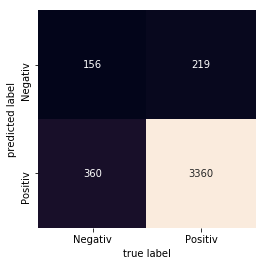

In [175]:
#Confusion matrix of model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = model.predict(X_test)
target_names = ['Negativ', 'Positiv']
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [176]:
from sklearn.model_selection import cross_val_score,  KFold

#kfold
kfold = KFold(n_splits=5)

#StratifiedKFold
#standard for cv=INT is stratified k-fold

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {}".format(scores.mean()))

Cross-validation scores: [0.85779677 0.85775336 0.86534351 0.85587786 0.85435115]
Mean accuracy: 0.8582245284342948


In [177]:
from sklearn.model_selection import cross_validate
res = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)

#make DataFrame of result for better Visualisation
res_df = pd.DataFrame(res)
display(res_df)

#Print Mean of all Scores
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,1.008953,0.195798,0.857797,0.929776
1,1.076886,0.209783,0.857753,0.930087
2,0.988977,0.195807,0.865344,0.932916
3,1.006958,0.187806,0.855878,0.930779
4,0.982983,0.191803,0.854351,0.928948


Mean times and scores:
 fit_time       1.012951
score_time     0.196199
test_score     0.858225
train_score    0.930501
dtype: float64


### Untersuchung der Predictions

In [178]:
# Erstellung eines DataFrames mit den Spalten: X_test, y_test, prediction
predictions = model.predict(X_test)
df_prediction = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'prediction': predictions
})

# neue Spalte, die Values von Spalten y_test und prediction vergleicht
df_prediction['vergleich'] = df_prediction['y_test'] == df_prediction['prediction']

df_prediction.head()

,X_test,y_test,prediction,vergleich
15806,"['tire', 'gauges', 'kind', 'thing', 'makes', '...",positiv,negativ,False
541,"['like', 'said', 'title', 'review', 'say', 'pr...",positiv,positiv,True
1724,"['comfortable', 'product', 'eliminate', 'stubb...",positiv,positiv,True
3586,"['must', 'tool', 'people', 'work', 'cars', 'se...",positiv,positiv,True
15830,"['purchased', 'joe', 'racing', 'pressure', 'ga...",positiv,positiv,True


In [179]:
# Speichern der Zeilen mit unterschiedlichen Werten in den Spalten "y_test" und "prediction" in einem neuen DF 
# und setzt Index zurück 
df_false_predictions = df_prediction[df_prediction.vergleich == False].reset_index(drop = True)

df_false_predictions.head()

,X_test,y_test,prediction,vergleich
0,"['tire', 'gauges', 'kind', 'thing', 'makes', '...",positiv,negativ,False
1,"['regulator', 'well', 'made', 'leak', 'job', '...",negativ,positiv,False
2,"['sleek', 'easy', 'mount', 'note', 'middle', '...",negativ,positiv,False
3,"['used', 'limited', 'fashion', 'preping', 'thi...",negativ,positiv,False
4,['ok'],positiv,negativ,False


In [180]:
# Erstellung einer CSV Datei mit den falsch predicteden Zeilen
df_false_predictions.to_csv("false_predictions.csv", sep=';',index=False)

In [181]:
# Ausgabe eines Reviews, das negativ ist aber positiv predicted wurde
df_false_predictions['X_test'].iloc[0]

"['tire', 'gauges', 'kind', 'thing', 'makes', 'many', 'people', 'excited', 'unless', 'gauge', 'poorly', 'designed', 'piece', 'junk', 'really', 'want', 'throw', 'trash', 'another', 'one', 'handy', 'keep', 'go', 'hassle', 'next', 'time', 'use', 'itdo', 'favor', 'get', 'one', 'well', 'made', 'usa', 'reasonably', 'priced', 'deadon', 'accurate', 'toss', 'old', 'one', 'away', 'give', 'someone', 'like', 'much', 'let', 'get', 'frustrated']"

In [182]:
# Ausgabe eines Reviews, das positiv ist aber negativ predicted wurde
df_false_predictions['X_test'].iloc[3]

"['used', 'limited', 'fashion', 'preping', 'thirteen', 'year', 'old', 'truck', 'admit', 'see', 'lot', 'difference', 'area', 'prepped', 'cleaning', 'clay', 'area', 'straight', 'polishing', 'compound', 'need', 'try', 'reaching', 'final', 'verdict']"